<a href="https://colab.research.google.com/github/kmayutrisna/SA_IMDB/blob/main/Amazon_word2vec_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary library
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import re
from gensim.models import Word2Vec

In [2]:
#Get the dataset from gdrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Display top of data
train_data =pd.read_csv("drive/My Drive/data/train_amazon.csv")
test_data = pd.read_csv("drive/My Drive/data/test_amazon.csv")

In [4]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [5]:
# Text preprocessing
from nltk.corpus import stopwords
def preprocess_text(text):

    # Text cleaning
    text = re.sub('[^a-zA-Z]', ' ', text)

    #Single character removal
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)

    #Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)

    # Lowercasing
    text = text.lower()

    # Lowercasing
    text = text.split()

    # Stopword removal
    stop_words = set(stopwords.words('english'))
    text = [word for word in text if not word in stop_words]

    # Join the tokens back to a single string
    text = ' '.join(text)
    return text

In [6]:
# Preprocess the text column
import re
train_data['text'] = train_data['text'].apply(preprocess_text)
test_data['text'] = test_data['text'].apply(preprocess_text)

In [7]:
X_train = train_data['text']
y_train = train_data['label']

X_test = test_data['text']
y_test = test_data['label']

In [8]:
# Tokenization and Padding
max_words = 10000
max_seq_length = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_seq, maxlen=max_seq_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_seq_length)

In [9]:
# Load Word2Vec Embeddings
embedding_dim = 300
from gensim.models import KeyedVectors

word2vec_model_path = 'drive/My Drive/data/GoogleNews-vectors-negative300.bin'

word2vec_model = KeyedVectors.load_word2vec_format(word2vec_model_path, binary=True)

#word2vec_model = Word2Vec.load(word2vec_model_path)
word_index = tokenizer.word_index

embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
    if i < max_words and word in word2vec_model:
        embedding_matrix[i] = word2vec_model[word]

In [10]:
# Build CNN Model
model = keras.Sequential([
    Embedding(max_words, embedding_dim, input_length=max_seq_length, weights=[embedding_matrix], trainable=False),
    Conv1D(128, 5, activation='relu'),
    MaxPooling1D(5),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [11]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
# Train the Model
epochs = 5
batch_size = 64

history = model.fit(X_train_padded, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

Epoch 1/5
450/450 [==============================] - 71s 153ms/step - loss: 0.4038 - accuracy: 0.8097 - val_loss: 0.3159 - val_accuracy: 0.8656
Epoch 2/5
450/450 [==============================] - 64s 141ms/step - loss: 0.2675 - accuracy: 0.8900 - val_loss: 0.2989 - val_accuracy: 0.8731
Epoch 3/5
450/450 [==============================] - 62s 138ms/step - loss: 0.1533 - accuracy: 0.9435 - val_loss: 0.4566 - val_accuracy: 0.8308
Epoch 4/5
450/450 [==============================] - 67s 149ms/step - loss: 0.0561 - accuracy: 0.9829 - val_loss: 0.4804 - val_accuracy: 0.8561
Epoch 5/5
450/450 [==============================] - 62s 138ms/step - loss: 0.0174 - accuracy: 0.9961 - val_loss: 0.5936 - val_accuracy: 0.8629


In [13]:
# Evaluate the Model
y_pred = model.predict(X_test_padded)
y_pred = (y_pred > 0.5).astype(int)


125/125 [==============================] - 3s 25ms/step


In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1 Score: {f1*100:.2f}%")

Accuracy: 85.80%
Precision: 85.89%
Recall: 86.48%
F1 Score: 86.19%


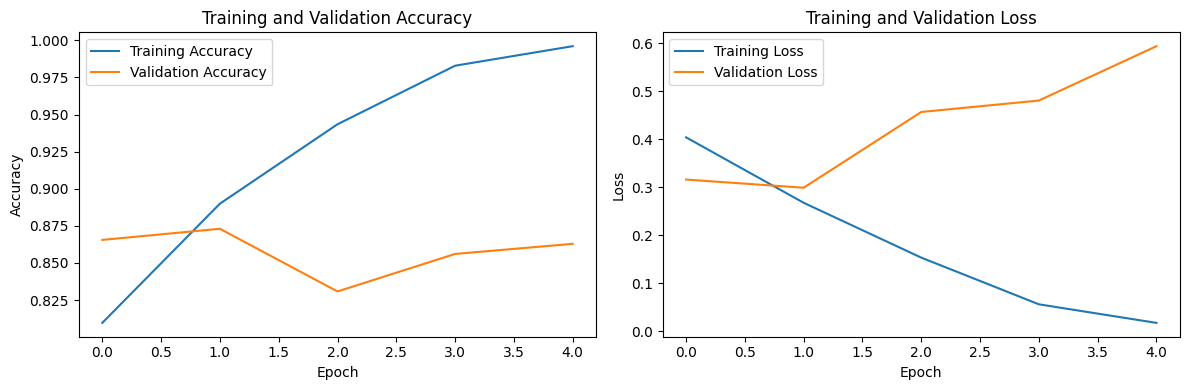

In [16]:
# Plot Training History (Accuracy and Loss)
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()